# Data Extraction & Database Population

This notebook extracts books from raw CSV datasets and populates the database with:
- Configurable number of books (sample or all)
- Extracted and deduplicated categories (many-to-many relationships)
- Aggregated ratings from Books_rating.csv
- No duplicate books in the database

## Datasets([Amazon Books Reviews - Kaggle](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data?select=books_data.csv)):
- `data/raw/books_data.csv` - Book metadata (~11k books)
- `data/raw/Books_rating.csv` - Ratings/reviews for books
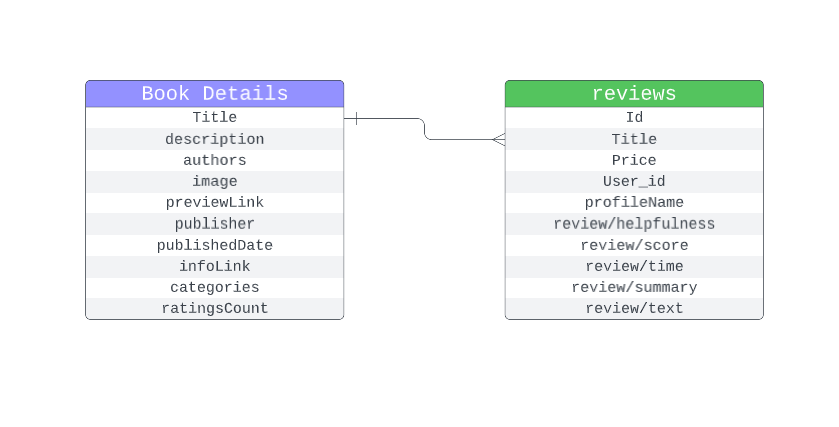



## 1. Setup and Imports

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Tuple

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from app.db.database import SessionLocal, engine, Base
from app.db import models, crud

print(f"Project root: {project_root}")
print(f"Database: {engine.url}")

Project root: c:\Users\pedra\OneDrive\Documentos\pfp\recommender_mvp
Database: sqlite:///c:\Users\pedra\OneDrive\Documentos\pfp\recommender_mvp\app\db\../../data/database.db


## 2. Load and Explore Raw Data

In [2]:
# Load books data
books_csv = project_root / "data/raw/books_data.csv"
ratings_csv = project_root / "data/raw/Books_rating.csv"

print(f"Loading books data from: {books_csv}")
books_df = pd.read_csv(books_csv)

print(f"\nBooks dataset shape: {books_df.shape}")
print(f"Columns: {list(books_df.columns)}")
print(f"\nFirst 3 rows:")
print(books_df.head(3))
print(f"\nData types:")
print(books_df.dtypes)
print(f"\nMissing values:")
print(books_df.isnull().sum())

Loading books data from: c:\Users\pedra\OneDrive\Documentos\pfp\recommender_mvp\data\raw\books_data.csv

Books dataset shape: (212404, 10)
Columns: ['Title', 'description', 'authors', 'image', 'previewLink', 'publisher', 'publishedDate', 'infoLink', 'categories', 'ratingsCount']

First 3 rows:
                                   Title  \
0         Its Only Art If Its Well Hung!   
1               Dr. Seuss: American Icon   
2  Wonderful Worship in Smaller Churches   

                                         description           authors  \
0                                                NaN  ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
2  This resource includes twelve principles in un...  ['David R. Ray']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?id=IjvHQ...   
2  http://books.google.com/books/content?id=2tsDA...   

      

In [3]:
# Load ratings data
print(f"Loading ratings data from: {ratings_csv}")
ratings_df = pd.read_csv(ratings_csv)

print(f"\nRatings dataset shape: {ratings_df.shape}")
print(f"Columns: {list(ratings_df.columns)}")
print(f"\nFirst 3 rows:")
print(ratings_df.head(3))
print(f"\nData types:")
print(ratings_df.dtypes)

Loading ratings data from: c:\Users\pedra\OneDrive\Documentos\pfp\recommender_mvp\data\raw\Books_rating.csv

Ratings dataset shape: (3000000, 10)
Columns: ['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']

First 3 rows:
           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   

             profileName review/helpfulness  review/score  review/time  \
0  Jim of Oz "jim-of-oz"                7/7           4.0    940636800   
1          Kevin Killian              10/10           5.0   1095724800   
2           John Granger              10/11           5.0   1078790400   

                                    review/summary  \
0           Nice collection of Julie Strain images   

In [4]:
## 2.2 Data Cleaning
def verify_missing_values(df: pd.DataFrame) -> None:
    """Check and report missing values in the DataFrame."""
    total_rows = len(df)
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            percent = (missing_count / total_rows) * 100
            print(f"Column '{col}' → {missing_count} missing values ({percent:.2f}%)")


print("\nBooks DataFrame missing values check:")
print("Verfying missing values of books_df")
verify_missing_values(books_df)

print("\nRatings DataFrame missing values check")
verify_missing_values(ratings_df)




Books DataFrame missing values check:
Verfying missing values of books_df
Column 'Title' → 1 missing values (0.00%)
Column 'description' → 68442 missing values (32.22%)
Column 'authors' → 31413 missing values (14.79%)
Column 'image' → 52075 missing values (24.52%)
Column 'previewLink' → 23836 missing values (11.22%)
Column 'publisher' → 75886 missing values (35.73%)
Column 'publishedDate' → 25305 missing values (11.91%)
Column 'infoLink' → 23836 missing values (11.22%)
Column 'categories' → 41199 missing values (19.40%)
Column 'ratingsCount' → 162652 missing values (76.58%)

Ratings DataFrame missing values check
Column 'Title' → 208 missing values (0.01%)
Column 'Price' → 2518829 missing values (83.96%)
Column 'User_id' → 561787 missing values (18.73%)
Column 'profileName' → 561905 missing values (18.73%)
Column 'review/summary' → 407 missing values (0.01%)
Column 'review/text' → 8 missing values (0.00%)


In [5]:
books_clean = books_df.where(pd.notna(books_df), None)
print(books_clean)
ratings_clean = ratings_df.where(pd.notna(ratings_df), None)
print(ratings_clean)

books_df = books_clean
ratings_df = ratings_clean



                                                    Title  \
0                          Its Only Art If Its Well Hung!   
1                                Dr. Seuss: American Icon   
2                   Wonderful Worship in Smaller Churches   
3                           Whispers of the Wicked Saints   
4       Nation Dance: Religion, Identity and Cultural ...   
...                                                   ...   
212399  The Orphan Of Ellis Island (Time Travel Advent...   
212400                            Red Boots for Christmas   
212401                                              Mamaw   
212402                                  The Autograph Man   
212403  Student's Solutions Manual for Johnson/Mowry's...   

                                              description  \
0                                                    None   
1       Philip Nel takes a fascinating look into the k...   
2       This resource includes twelve principles in un...   
3       Julia Thomas fi

In [6]:
# books_cleaned_csv = project_root / "data/processed/book_cleaned.csv"
# rating_cleaned_csv = project_root / "data/processed/rating_cleaned.csv"

# books_df.to_csv(books_cleaned_csv)
# ratings_df.to_csv(rating_cleaned_csv)

In [7]:
books_df['publisher'].value_counts()

publisher
Simon and Schuster               3454
Penguin                          2825
Routledge                        2394
John Wiley & Sons                2031
Harper Collins                   1911
                                 ... 
DayPack Books                       1
Smart about History                 1
SAP PRESS                           1
Tower Hill Press                    1
Selected Christian Literature       1
Name: count, Length: 16016, dtype: int64

In [8]:
books_df['ratingsCount'].value_counts()

ratingsCount
1.0       20919
2.0        8249
3.0        4393
4.0        2798
5.0        1995
          ...  
1306.0        1
2950.0        1
225.0         1
1180.0        1
321.0         1
Name: count, Length: 478, dtype: int64

In [9]:
ratings_df.describe()

,Price,review/score,review/time
count,481171.000000,3.000000e+06,3.000000e+06
mean,21.762656,4.215289e+00,1.132307e+09
std,26.206541,1.203054e+00,1.493202e+08
min,1.000000,1.000000e+00,-1.000000e+00
25%,10.780000,4.000000e+00,9.999072e+08
50%,14.930000,5.000000e+00,1.128298e+09
75%,23.950000,5.000000e+00,1.269130e+09
max,995.000000,5.000000e+00,1.362355e+09


## 3. Extract and Deduplicate Categories

In [10]:
import ast

def extract_categories(books_df: pd.DataFrame, category_column: str = 'categories') -> Dict[str, int]:
    """
    Extract unique categories from books dataframe.
    
    Categories are stored as string representations of Python lists: "['Category1', 'Category2']"
    
    Args:
        books_df: DataFrame with book data
        category_column: Name of the column containing categories
    
    Returns:
        Dictionary with category names and their counts
    """
    all_categories = {}
    
    for categories_str in books_df[category_column].dropna():
        if pd.isna(categories_str):
            continue
        
        try:
            # Parse the string representation of a list
            # e.g., "['Comics & Graphic Novels']" -> ['Comics & Graphic Novels']
            categories_list = ast.literal_eval(str(categories_str))
            
            if isinstance(categories_list, list):
                for cat in categories_list:
                    cat = str(cat).strip()
                    if cat:
                        all_categories[cat] = all_categories.get(cat, 0) + 1
        except (ValueError, SyntaxError):
            # If parsing fails, try splitting by comma
            categories = [cat.strip() for cat in str(categories_str).split(',')]
            for cat in categories:
                if cat:
                    all_categories[cat] = all_categories.get(cat, 0) + 1
    
    return dict(sorted(all_categories.items(), key=lambda x: x[1], reverse=True))

# Extract categories
categories_dict = extract_categories(books_df)

print(f"\n{'='*60}")
print(f"UNIQUE CATEGORIES EXTRACTED: {len(categories_dict)}")
print(f"{'='*60}")
print(f"\nTop 20 categories by frequency:")
for i, (cat, count) in enumerate(list(categories_dict.items())[:20], 1):
    print(f"{i:2d}. {cat:30s} - {count:5d} books")

print(f"\n...")
print(f"\nLast 10 categories (least frequent):")
for i, (cat, count) in enumerate(list(categories_dict.items())[-10:], len(categories_dict)-9):
    print(f"{i:2d}. {cat:30s} - {count:5d} books")


UNIQUE CATEGORIES EXTRACTED: 10883

Top 20 categories by frequency:
 1. Fiction                        - 23419 books
 2. Religion                       -  9459 books
 3. History                        -  9330 books
 4. Juvenile Fiction               -  6643 books
 5. Biography & Autobiography      -  6324 books
 6. Business & Economics           -  5625 books
 7. Computers                      -  4312 books
 8. Social Science                 -  3834 books
 9. Juvenile Nonfiction            -  3446 books
10. Science                        -  2623 books
11. Education                      -  2611 books
12. Cooking                        -  2445 books
13. Sports & Recreation            -  2267 books
14. Family & Relationships         -  2178 books
15. Literary Criticism             -  2147 books
16. Music                          -  2106 books
17. Medical                        -  2079 books
18. Art                            -  2054 books
19. Body, Mind & Spirit            -  2049 books


In [11]:
# Extract authors
authors_dict = extract_categories(books_df, 'authors')

print(f"\n{'='*60}")
print(f"UNIQUE authors EXTRACTED: {len(authors_dict)}")
print(f"{'='*60}")
print(f"\nTop 20 authors by frequency:")
for i, (cat, count) in enumerate(list(authors_dict.items())[:20], 1):
    print(f"{i:2d}. {cat:30s} - {count:5d} books")

print(f"\n...")
print(f"\nLast 10 authors (least frequent):")
for i, (cat, count) in enumerate(list(categories_dict.items())[-10:], len(categories_dict)-9):
    print(f"{i:2d}. {cat:30s} - {count:5d} books")



UNIQUE authors EXTRACTED: 153055

Top 20 authors by frequency:
 1. Rose Arny                      -   236 books
 2. William Shakespeare            -   228 books
 3. Library of Congress. Copyright Office -   178 books
 4. Agatha Christie                -   148 books
 5. Erle Stanley Gardner           -   128 books
 6. Louis L'Amour                  -   125 books
 7. Charles Dickens                -   108 books
 8. Isaac Asimov                   -    96 books
 9. Mark Twain                     -    90 books
10. Edgar Rice Burroughs           -    89 books
11. Rudyard Kipling                -    87 books
12. Francine Pascal                -    84 books
13. Various                        -    78 books
14. Zane Grey                      -    77 books
15. Library of Congress            -    77 books
16. Lonely Planet                  -    75 books
17. Ann M. Martin                  -    74 books
18. Robert Louis Stevenson         -    74 books
19. Henry James                    -    71 book

In [12]:
# publisher
publisher_dict = extract_categories(books_df, 'publisher')

print(f"\n{'='*60}")
print(f"UNIQUE publishers EXTRACTED: {len(publisher_dict)}")
print(f"{'='*60}")
print(f"\nTop 20 publisher by frequency:")
for i, (cat, count) in enumerate(list(publisher_dict.items())[:20], 1):
    print(f"{i:2d}. {cat:30s} - {count:5d} books")

print(f"\n...")
print(f"\nLast 10 authors (least frequent):")
for i, (cat, count) in enumerate(list(categories_dict.items())[-10:], len(categories_dict)-9):
    print(f"{i:2d}. {cat:30s} - {count:5d} books")



UNIQUE publishers EXTRACTED: 16396

Top 20 publisher by frequency:
 1. Simon and Schuster             -  3456 books
 2. Penguin                        -  2826 books
 3. Routledge                      -  2396 books
 4. John Wiley & Sons              -  2031 books
 5. Harper Collins                 -  1911 books
 6. Oxford University Press        -  1550 books
 7. Inc.                           -  1520 books
 8. Cambridge University Press     -  1486 books
 9. Macmillan                      -  1233 books
10. Courier Corporation            -  1116 books
11. Vintage                        -  1004 books
12. Open Road Media                -   983 books
13. iUniverse                      -   929 books
14. Houghton Mifflin Harcourt      -   890 books
15. Springer Science & Business Media -   886 books
16. Random House                   -   832 books
17. USA                            -   739 books
18. HarperCollins                  -   611 books
19. Hachette UK                    -   606 book

## 4. Aggregate Ratings by Book

In [ ]:
def aggregate_ratings(ratings_df: pd.DataFrame, match_column: str = 'Title') -> Dict[str, Dict]:
    """
    Aggregate ratings by Title (matching with books).
    
    Using Books_rating.csv with columns:
    - Title: Book title
    - review/score: Rating value
    
    Args:
        ratings_df: DataFrame with ratings
        match_column: Column to group by (Title for matching with books)
    
    Returns:
        Dictionary with aggregated ratings per book title
    """
    aggregated = {}
    
    for _, row in ratings_df.iterrows():
        key = str(row.get(match_column, '')).strip()
        
        if not key or key == 'None' or key == '':
            continue
        
        if key not in aggregated:
            aggregated[key] = {
                'ratings': [],
                'count': 0,
                'avg': 0.0
            }
        
        try:
            # Books_rating.csv uses 'review/score' column
            rating = float(row.get('review/score', 0))
            if 0 <= rating <= 5:
                aggregated[key]['ratings'].append(rating)
        except (ValueError, TypeError):
            pass
    
    # Calculate averages
    for key in aggregated:
        ratings = aggregated[key]['ratings']
        aggregated[key]['count'] = len(ratings)
        aggregated[key]['avg'] = round(np.mean(ratings), 2) if ratings else 0.0
    
    return aggregated

# Aggregate ratings
print("Aggregating ratings by Title...")
ratings_agg = aggregate_ratings(ratings_df)

print(f"\n{'='*60}")
print(f"RATINGS AGGREGATION")
print(f"{'='*60}")
print(f"Books with ratings: {len(ratings_agg)}")
print(f"Total ratings: {sum(r['count'] for r in ratings_agg.values())}")

# Show some stats
ratings_counts = [r['count'] for r in ratings_agg.values()]
ratings_avgs = [r['avg'] for r in ratings_agg.values()]

print(f"\nRatings count per book:")
print(f"  Min: {min(ratings_counts) if ratings_counts else 0}")
print(f"  Max: {max(ratings_counts) if ratings_counts else 0}")
print(f"  Avg: {np.mean(ratings_counts):.1f}")

print(f"\nAverage rating per book:")
print(f"  Min: {min(ratings_avgs) if ratings_avgs else 0:.2f}")
print(f"  Max: {max(ratings_avgs) if ratings_avgs else 0:.2f}")
print(f"  Avg: {np.mean(ratings_avgs):.2f}")

Aggregating ratings by Title...


In [ ]:
for i, (title, stats) in enumerate(list(ratings_agg.items())[:10], 1):
    print(f"{i:2d}. '{title}' - Count: {stats['count']}, Avg: {stats['avg']:.2f}")

for ratings_avgs in sorted(ratings_agg.items(), key=lambda x: x[1]['avg'], reverse=True)[:10]:
    title, stats = ratings_avgs
    print(f"'{title}' - Count: {stats['count']}, Avg: {stats['avg']:.2f}")

 1. 'Its Only Art If Its Well Hung!' - Count: 1, Avg: 4.00
 2. 'Dr. Seuss: American Icon' - Count: 9, Avg: 4.56
 3. 'Wonderful Worship in Smaller Churches' - Count: 4, Avg: 5.00
 4. 'Whispers of the Wicked Saints' - Count: 32, Avg: 3.72
 5. 'Nation Dance: Religion, Identity and Cultural Difference in the Caribbean' - Count: 1, Avg: 5.00
 6. 'The Church of Christ: A Biblical Ecclesiology for Today' - Count: 4, Avg: 4.50
 7. 'The Overbury affair (Avon)' - Count: 1, Avg: 3.00
 8. 'A Walk in the Woods: a Play in Two Acts' - Count: 3, Avg: 4.67
 9. 'Saint Hyacinth of Poland' - Count: 2, Avg: 4.50
10. 'Rising Sons and Daughters: Life Among Japan's New Young' - Count: 3, Avg: 4.33
'Wonderful Worship in Smaller Churches' - Count: 4, Avg: 5.00
'Nation Dance: Religion, Identity and Cultural Difference in the Caribbean' - Count: 1, Avg: 5.00
'A husband for Kutani' - Count: 1, Avg: 5.00
'Gold and greenstone' - Count: 1, Avg: 5.00
'The Repeal of Reticence: A History of America's Cultural and Legal 

## 5. Configure Sample Size and Populate Database

In [ ]:
# ============================================================
# CONFIGURATION: Adjust these values for your needs
# ============================================================

N_BOOKS = 100  # Set to None to load ALL books, or specify a number (e.g., 100, 1000)
SKIP_DUPLICATES = True  # Skip books already in database
SKIP_EXISTING_DB = True  # Drop existing data and recreate tables

print(f"{'='*60}")
print(f"CONFIGURATION")
print(f"{'='*60}")
print(f"N_BOOKS: {N_BOOKS if N_BOOKS else 'ALL'}")
print(f"SKIP_DUPLICATES: {SKIP_DUPLICATES}")
print(f"SKIP_EXISTING_DB: {SKIP_EXISTING_DB}")
print(f"{'='*60}")

# Get sample of books to extract
sample_df = books_df.head(N_BOOKS) if N_BOOKS else books_df

print(f"\nSample size: {len(sample_df)} books")
print(f"Categories in sample: {len(extract_categories(sample_df))}")

CONFIGURATION
N_BOOKS: 100
SKIP_DUPLICATES: True
SKIP_EXISTING_DB: True

Sample size: 100 books
Categories in sample: 46


In [ ]:
# Create database tables
if SKIP_EXISTING_DB:
    print("Recreating database tables...")
    Base.metadata.drop_all(engine)
    Base.metadata.create_all(engine)
    print("✓ Database tables created")

# Initialize session
db = SessionLocal()
print(f"✓ Database session initialized")

Recreating database tables...
✓ Database tables created
✓ Database session initialized


In [ ]:
def populate_books_to_db(
    db,
    books_df: pd.DataFrame,
    ratings_agg: Dict[str, Dict],
    skip_duplicates: bool = True
) -> Tuple[int, int, set, set]:
    """
    Populate database with books, categories, and ratings.
    
    Args:
        db: Database session
        books_df: DataFrame with book data
        ratings_agg: Aggregated ratings dictionary
        skip_duplicates: Skip if book already exists
    
    Returns:
        Tuple of (books_created, books_skipped, categories_created, authors_created)
    """
    books_created = 0
    books_skipped = 0
    categories_created = set()
    authors_created = set()
    
    for idx, row in books_df.iterrows():
        try:
            # Column names are case-sensitive - use exact names from CSV
            title = str(row.get('Title', row.get('title', ''))).strip()
            
            if not title:
                continue
            
            # Check for duplicates
            existing = db.query(models.Book).filter_by(title=title).first()
            if existing:
                if skip_duplicates:
                    books_skipped += 1
                    continue
                else:
                    db.delete(existing)
                    db.commit()
            
            # Extract book data - use correct column names
            authors = str(row.get('authors', row.get('Author', ''))).strip() or None
            categories_raw = str(row.get('categories', row.get('Category', ''))).strip() or None
            description = str(row.get('description', row.get('Description', ''))).strip() or None
            image_url = str(row.get('image', row.get('Image_URL', ''))).strip() or None
            info_link = str(row.get('infoLink', row.get('Info_Link', ''))).strip() or None
            publisher = str(row.get('publisher', row.get('Publisher', ''))).strip() or None
            published_date = str(row.get('publishedDate', row.get('Published_Date', ''))).strip() or None
            
            # Handle price and ratings count
            try:
                price = float(row.get('Price', row.get('price', 0))) if pd.notna(row.get('Price', row.get('price'))) else None
            except (ValueError, TypeError):
                price = None
            
            try:
                ratings_count = int(row.get('ratingsCount', 0)) if pd.notna(row.get('ratingsCount', 0)) else 0
            except (ValueError, TypeError):
                ratings_count = 0
                        
            # Get aggregated ratings if available
            ratings_data = ratings_agg.get(title, {})
            avg_rating = ratings_data.get('avg', 0.0)
            if ratings_count == 0:
                ratings_count = ratings_data.get('count', 0)
            
            # Parse categories - they come as string representation of Python list
            category_names = []
            if categories_raw and categories_raw != 'None':
                try:
                    # Try to parse as Python list string
                    categories_list = ast.literal_eval(categories_raw)
                    if isinstance(categories_list, list):
                        category_names = [str(cat).strip() for cat in categories_list if cat]
                except (ValueError, SyntaxError):
                    # If parsing fails, try splitting by comma
                    category_names = [cat.strip() for cat in categories_raw.split(',') if cat.strip()]
                
                # Add to created set
                for cat in category_names:
                    categories_created.add(cat)
                        # Parse categories - they come as string representation of Python list
            
            authors_name = []
            if authors and authors != 'None':
                try:
                    # Try to parse as Python list string
                    authors_list = ast.literal_eval(authors)
                    if isinstance(authors_list, list):
                        authors_name = [str(aut).strip() for aut in authors_list if aut]
                except (ValueError, SyntaxError):
                    # If parsing fails, try splitting by comma
                    authors_name = [aut.strip() for aut in authors.split(',') if aut.strip()]
                
                # Add to created set
                for aut in authors_name:
                    authors_created.add(aut)

            # Create book with many-to-many categories
            crud.create_book(
                db=db,
                title=title,
                authors=authors_name,
                categories=category_names,
                description=description,
                image=image_url,
                info_link=info_link,
                publisher=publisher,
                published_date=published_date,
                ratings_count=ratings_count,
                avg_rating=avg_rating,
                price=price,
            )
            books_created += 1
            
            if (books_created + books_skipped) % 50 == 0:
                print(f"  Progress: {books_created} created, {books_skipped} skipped")
        
        except Exception as e:
            print(f"  ✗ Error creating book (row {idx}): {e}")
            books_skipped += 1
    
    return books_created, books_skipped, categories_created, authors_created

print("Populating database with books and categories...")
print(f"{'='*60}")

books_created, books_skipped, categories_created, authors_created = populate_books_to_db(
    db,
    sample_df,
    ratings_agg,
    skip_duplicates=SKIP_DUPLICATES
)

print(f"{'='*60}")
print(f"✓ Books populated:")
print(f"  Created: {books_created}")
print(f"  Skipped: {books_skipped}")
print(f"  Categories created: {len(categories_created)}")
print(f"  Categories: {sorted(list(categories_created))[:10]}...")
print(f"  Authors created: {len(authors_created)}")
print(f"  Authors: {sorted(list(authors_created))[:10]}...")
print(f"{'='*60}")

Populating database with books and categories...


c:\Users\pedra\OneDrive\Documentos\pfp\recommender_mvp\app\db\crud.py:115: SAWarning: Object of type <Book> not in session, add operation along 'Category.books' won't proceed
  db.commit()
c:\Users\pedra\OneDrive\Documentos\pfp\recommender_mvp\app\db\crud.py:115: SAWarning: Object of type <Book> not in session, add operation along 'Author.books' won't proceed
  db.commit()


  Progress: 50 created, 0 skipped
  Progress: 100 created, 0 skipped
✓ Books populated:
  Created: 100
  Skipped: 0
  Categories created: 46
  Categories: ['Adventure stories', 'America', 'Architecture', 'Art', 'Bible stories, English', 'Biography & Autobiography', 'Body, Mind & Spirit', 'Business & Economics', "Children's libraries", 'Comics & Graphic Novels']...
  Authors created: 116
  Authors: ['Alan Nourse', 'Allen Gersho', 'Anthony Capella', 'Armando Salda A-Mora', 'Arthur J. Droge', 'Barry Crump', 'Bill Franz', 'BroadStreet Publishing Group LLC', 'Camillia Fawzi El-Solh', 'Cara Delevingne']...


## 6. Verify Database Population

In [ ]:
# Verify data
total_books = db.query(models.Book).count()
total_categories = db.query(models.Category).count()
total_authors = db.query(models.Category).count()
total_users = db.query(models.User).count()

print(f"\n{'='*60}")
print(f"DATABASE VERIFICATION")
print(f"{'='*60}")
print(f"Total books: {total_books}")
print(f"Total categories: {total_categories}")
print(f"Total authors: {total_authors}")
print(f"Total users: {total_users}")
print(f"{'='*60}\n")

# Show sample books with their categories
print("Sample books with categories:")
print(f"{'='*60}")
sample_books = db.query(models.Book).limit(5).all()

for book in sample_books:
    categories = [cat.name for cat in book.categories_rel]
    print(f"\nTitle: {book.title}")
    print(f"  Authors: {book.authors}")
    print(f"  Categories: {', '.join(categories) if categories else 'None'}")
    print(f"  Ratings: {book.ratings_count} ratings, avg {book.avg_rating:.2f}")
    if book.price: # type: ignore
        print(f"  Price: ${book.price:.2f}")

print(f"\n{'='*60}")

# Show all unique categories
print("\nAll categories in database:")
all_cats = db.query(models.Category).order_by(models.Category.name).all()
for i, cat in enumerate(all_cats, 1):
    num_books = len(cat.books)
    print(f"{i:3d}. {cat.name:30s} - {num_books:4d} books")

# Show all unique authors
print("\nAll authors in database:")
all_aut = db.query(models.Author).order_by(models.Author.name).all()
for i, aut in enumerate(all_aut, 1):
    num_books = len(aut.books)
    print(f"{i:3d}. {aut.name:30s} - {num_books:4d} books")

print(f"\n{'='*60}")
print(f"✓ Database population complete!")
print(f"{'='*60}")


DATABASE VERIFICATION
Total books: 100
Total categories: 46
Total authors: 46
Total users: 0

Sample books with categories:

Title: Its Only Art If Its Well Hung!
  Authors: ['Julie Strain']
  Categories: Comics & Graphic Novels
  Ratings: 1 ratings, avg 4.00

Title: Dr. Seuss: American Icon
  Authors: ['Philip Nel']
  Categories: Biography & Autobiography
  Ratings: 9 ratings, avg 4.56

Title: Wonderful Worship in Smaller Churches
  Authors: ['David R. Ray']
  Categories: Religion
  Ratings: 4 ratings, avg 5.00

Title: Whispers of the Wicked Saints
  Authors: ['Veronica Haddon']
  Categories: Fiction
  Ratings: 32 ratings, avg 3.72

Title: Nation Dance: Religion, Identity and Cultural Difference in the Caribbean
  Authors: ['Edward Long']
  Categories: None
  Ratings: 1 ratings, avg 5.00


All categories in database:
  1. Adventure stories              -    1 books
  2. America                        -    1 books
  3. Architecture                   -    1 books
  4. Art              

In [ ]:
# Close database session when done
db.close()
print("Database session closed")

Database session closed
